## GAN


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

### Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Данные - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels 
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
names = np.array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'class'])
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data", header=None)
data.columns = names
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Задача заключается в генерации параметров кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов
- $Y$ - метки классов

In [5]:
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == 'h'] = 0

In [6]:
y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

### Визуализация данных

In [7]:
|def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i+1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

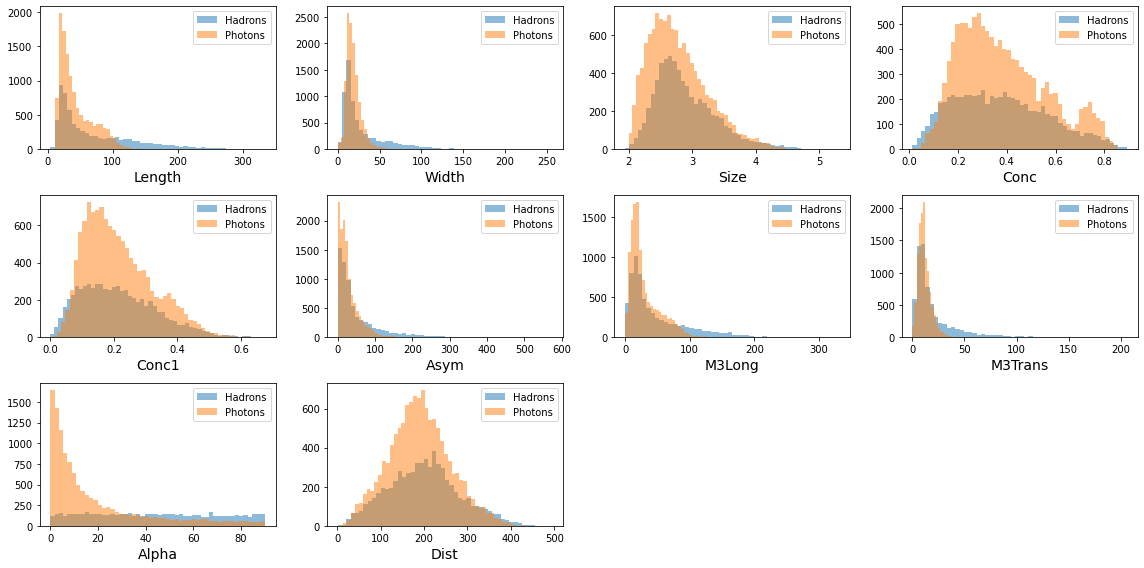

In [8]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

### Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому, нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты. 

In [9]:
QunTran = QuantileTransformer(random_state=11, output_distribution='normal')
X_qt = QunTran.fit_transform(X)

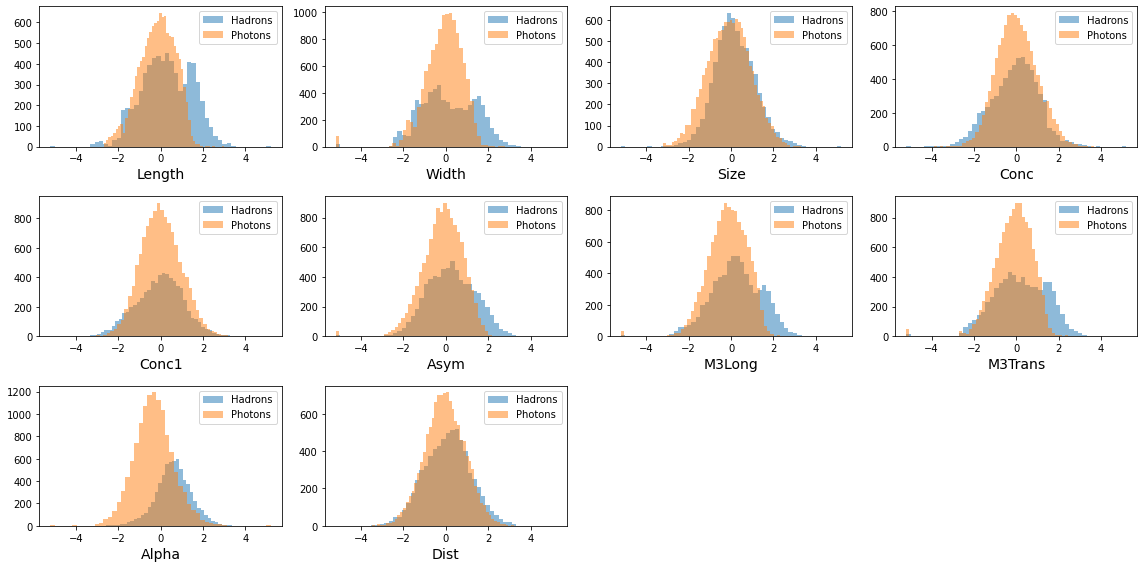

In [10]:
plot_hists(X_qt[y[:, 0]==0], X_qt[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

### Обучающая и тестовая выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_qt, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

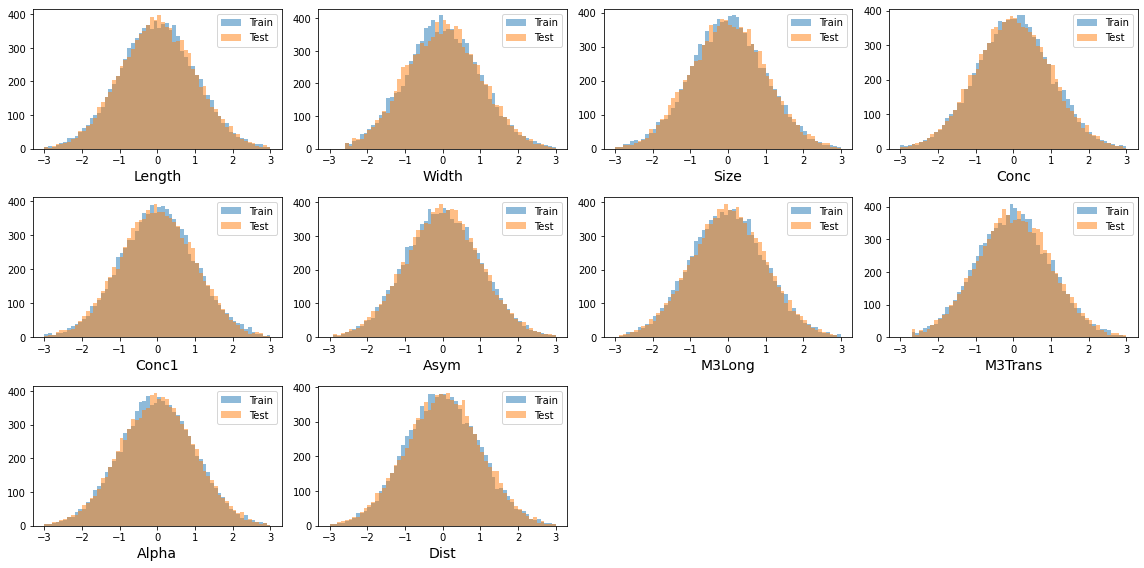

In [13]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

### Conditional WGAN

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Класс генератора

In [19]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
            )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1).to(DEVICE)
        return self.net(zy)

### Класс дискриминатора

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.n_inputs = n_inputs
        
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100), 
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
            )

    def forward(self, x, y):
      for p in self.parameters():
        p.data.clamp_(-0.01, 0.01)
      xy = torch.cat((x, y), dim=1).to(DEVICE)
      return self.net(xy)

### Класс обучения

In [20]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    
    def gan_loss(self, real_objects_scores, gen_objects_scores, by):

      if by=='generator':
          return - gen_objects_scores.mean()
      elif by == 'discriminator':
          return gen_objects_scores.mean() - real_objects_scores.mean()


    def fit(self, X, y):
        
 
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
    
        dataset_real = TensorDataset(X_real, y_cond)
        

        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
              
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)    
            
                new = torch.normal(0, 1, (real_batch.shape[0], self.latent_dim))

                gen_ob = self.generator(new, cond_batch)
                real_ob_scores, gen_objects_scores = torch.split(self.discriminator(torch.cat([real_batch, gen_ob], dim=0), 
                                                                  torch.cat([cond_batch, cond_batch], dim=0)), real_batch.shape[0])

                if (i % (1 + self.n_critic)) < 1:
                  self.opt_gen.zero_grad()
                  gen_loss = self.gan_loss(real_ob_scores, gen_objects_scores, by='generator')
                  gen_loss.backward()
                  
                  self.opt_gen.step()

                else:
                  self.opt_disc.zero_grad()
                  discr_loss = self.gan_loss(real_ob_scores, gen_objects_scores, by='discriminator')
                  discr_loss.backward()

                  self.opt_disc.step()
                  


            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())
                    

        self.generator.train(False)
        self.discriminator.train(False)

### Обучение
Обучим модель на данных.

In [21]:
%%time
latent_dim = 10
generator     = Generator(n_inputs=latent_dim+y.shape[1], 
                          n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1]+y.shape[1])

fitter = Fitter(generator, discriminator, batch_size=50, n_epochs=250, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train, y_train)

CPU times: user 1min 42s, sys: 310 ms, total: 1min 42s
Wall time: 1min 45s


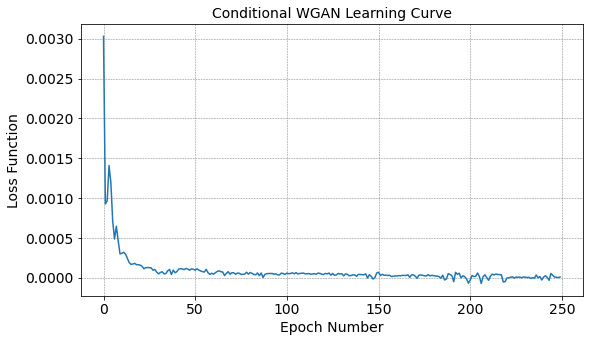

In [22]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

### Генерация X по y

In [23]:
def generate(generator, y, latent_dim):
    
    Z_noise = torch.normal(0, 1, (len(y), latent_dim), dtype=torch.float)
    X_fake = generator(Z_noise.to(DEVICE), torch.tensor(y, dtype=torch.float, device=DEVICE))
    
    return X_fake.detach().numpy() 

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [24]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

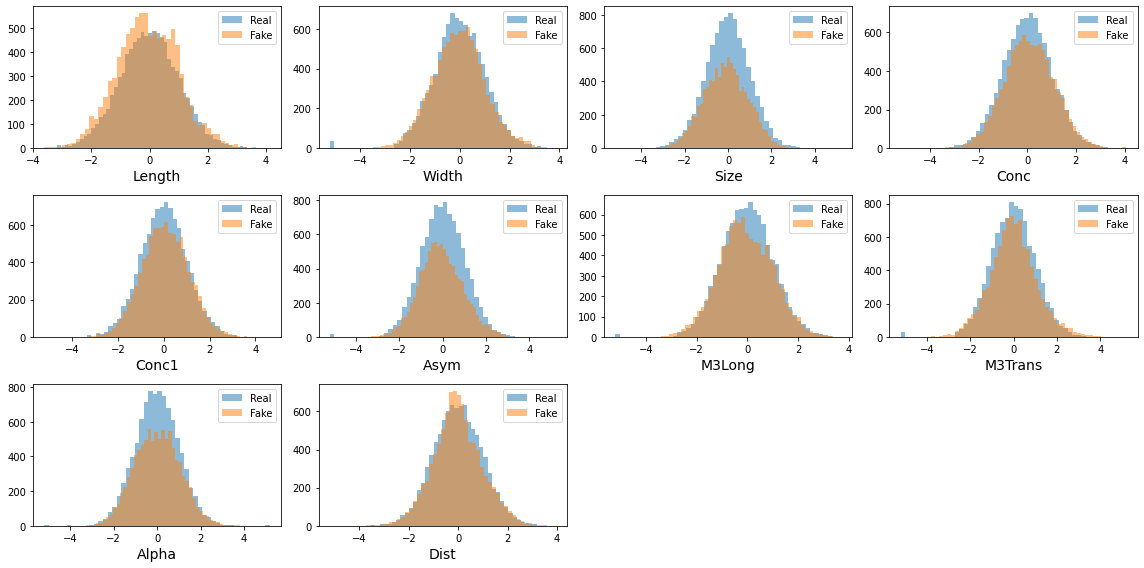

In [25]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [26]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

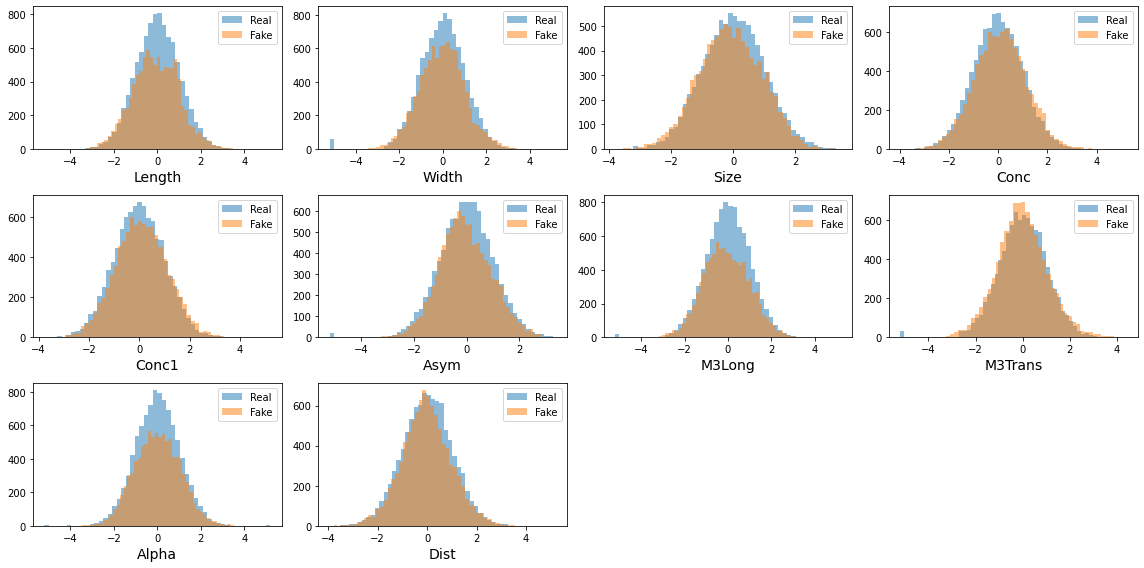

In [27]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

### Измерение качества генерации



In [28]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6596173378844119


Идеальное значение ROC AUC равно 0.5. Это соответствует случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.66

### Encoder


In [33]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()
        
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
            )
        
        self.mu = nn.Linear(100 , lat_size)
        self.log_sigma = nn.Linear(100 , lat_size)
        
        
    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma

### Decoder



In [32]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()
        
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        
    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

### Класс для обучения вариационного автокодировщика.

In [35]:
class VAEFitter(object):
    
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, KL_weight=0.001):
        
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        return KL*self.KL_weight + recon_loss
    
    
    def compute_loss(self, x_batch, cond_batch):

        new = self.sample_z(self.encoder(x_batch, cond_batch)[0],self.encoder(x_batch, cond_batch)[1])
        reconstructed_x = self.decoder(new, cond_batch)
        
        loss = self.custom_loss(x_batch, reconstructed_x, self.encoder(x_batch, cond_batch)[0],self.encoder(x_batch, cond_batch)[1])
        
        return loss
    
    
    def fit(self, X, y):
        
       
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        
        dataset_real = TensorDataset(X_real, y_cond)
        
       
        self.encoder.train(True)
        self.decoder.train(True)
        
        self.loss_history = []

       
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                
                loss = self.compute_loss(x_batch, cond_batch)
                
                
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
            
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        
        self.encoder.train(False)
        self.decoder.train(False)

### Обучение


In [36]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(encoder, decoder, batch_size=50, n_epochs=250, latent_dim=latent_dim, lr=0.001, KL_weight=0.001)
vae_fitter.fit(X_train, y_train)

CPU times: user 3min 43s, sys: 725 ms, total: 3min 44s
Wall time: 3min 53s


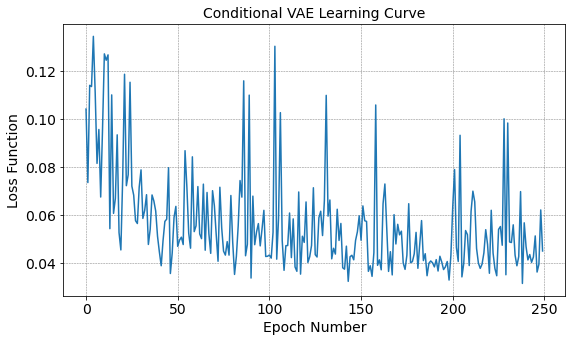

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

### Генерация X по y

In [38]:
def generate(decoder, y, latent_dim):
    
    noise = torch.normal(0, 1, (len(y), latent_dim), dtype=torch.float)
    X_fake = decoder(noise.to(DEVICE), torch.tensor(y, dtype=torch.float, device=DEVICE))
    
    return X_fake.detach().numpy() 

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [39]:
X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

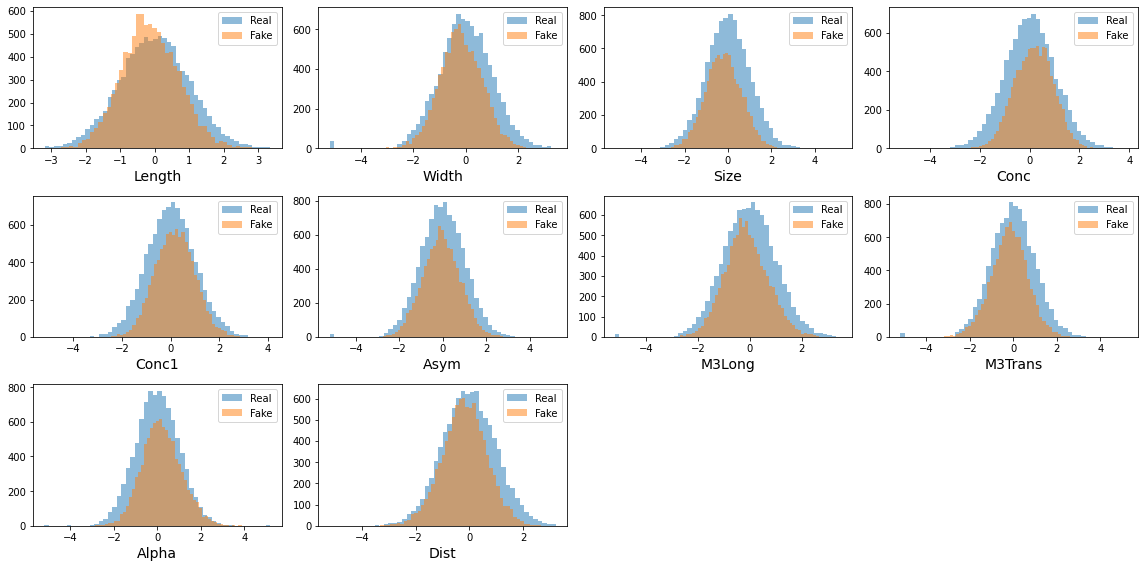

In [40]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [41]:
X_fake_test = generate(vae_fitter.decoder, y_test, latent_dim)

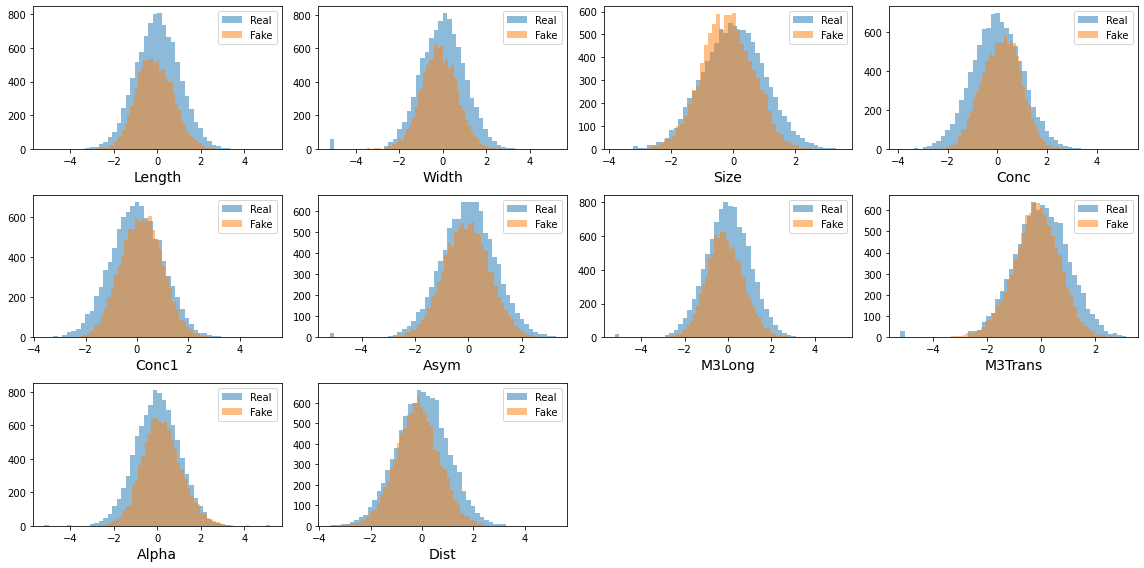

In [42]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

# Измерение качества генерации

In [43]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [45]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6918102921159972


Для CVAE получили ROC AUC около 0.7. Таким образом видим, что в данной задаче обе модели ведут себя схожим образом. 